# Getting started with coherence

These are instructions from Zach from an email on 9/3/25. 

He sent me a selection of test data called test_stack.slc located in data/test_data_zach

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d 


In [2]:
data_file = '/Users/julo9057/Library/CloudStorage/OneDrive-UCB-O365/Documents/cryogars/data/test_data_zach/test_stack.slc'
stack = np.fromfile(data_file, '<c8').reshape(13, 1000, 1000)

Text(0.5, 1.0, 'Phase change (radians)')

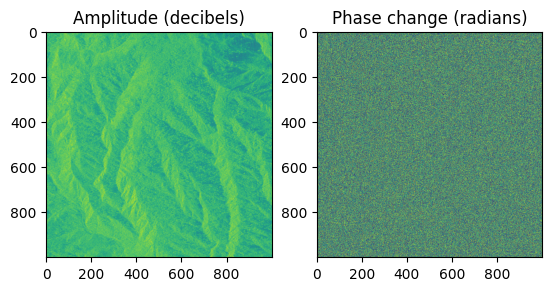

In [3]:
image_n = 0
fig, axes = plt.subplots(1, 2)
axes[0].imshow(10*np.log10(np.abs(stack)[image_n])) # decibels
axes[1].imshow(np.angle(stack)[image_n]) # radians

axes[0].set_title("Amplitude (decibels)")
axes[1].set_title("Phase change (radians)")

## Calculating coherence 

Now that I have phase and amplitude, I can calculate the coherence. 
This is the equation for modeling coherence over time that I got from Zach: 
$$ \gamma(t) = (1-\rho_{\infty})e^{t/r} + \rho_{\infty} $$
This states that coherence is a negative exponential function where the slope and steepness of the slope depends on $r$ which is ?

This is equation (36) from this paper by [Bamler](https://iopscience.iop.org/article/10.1088/0266-5611/14/4/001)
$$ \gamma = \frac{E[u_1u^∗_2]}{\sqrt{E[|u_1|^2 ]E[|u_2|^2 ]}} $$


The amplitude and phase of any given pixel can be written as either $(\theta, amplitude)$ or $x+yi$/$x+yj$ (as an imaginary number). NOTE: $j$ is usually used in physics (or signal processing) instead of $i$. 
We use the imaginary number as a basis for this calculation, since the expected values can basically be treated as cross products of two vectors. 

In [4]:
# Calculate the coherence magnitude over 13x13 pixels 
# img1 and img2 should be the same size
def calc_coherence_unweighted(img1, img2, window=13) :

    # create window over which to do the magnitude calculation 
    kernel = np.ones((window, window), dtype=np.float32)
    kernel /= kernel.sum()

    # Numerator: E[u1 * conj(u2)] a.k.a. the cross product of the two complex numbers
    cross_prod = img1 * np.conj(img2)

    # convolve2d does the leg work of moving the window over all pixels. 
    # the 'symm' boundary creates a mirror reflection to fill in areas for pixels at the edges
    num_real = convolve2d(cross_prod.real, kernel, mode='same', boundary='symm')
    num_imag = convolve2d(cross_prod.imag, kernel, mode='same', boundary='symm')
    # put the separate components back together 
    numerator = num_real + 1j * num_imag

    # Denominator: sqrt(E[|u1|^2] * E[|u2|^2])
    power1 = convolve2d(np.abs(img1)**2, kernel, mode='same', boundary='symm')
    power2 = convolve2d(np.abs(img2)**2, kernel, mode='same', boundary='symm')
    denom = np.sqrt(power1 * power2)
    denom[denom == 0] = 1e-12  # Prevent divide by zero

    # Coherence magnitude
    coherence = np.abs(numerator / denom)
    return coherence


In [ ]:
coherence_0_1 = calc_coherence_unweighted(stack[0], stack[1])
coherence_0_2 = calc_coherence_unweighted(stack[0], stack[2])
coherence_0_9 = calc_coherence_unweighted(stack[8], stack[9])

Text(0.5, 1.0, 'Coherence 0 and 9')

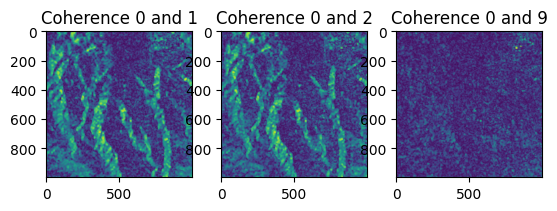

In [ ]:
fig, axes = plt.subplots(1, 3)
axes[0].imshow(coherence_0_1) 
axes[1].imshow(coherence_0_2) 
axes[2].imshow(coherence_8_9) 
axes[0].set_title("Coherence 0 and 1")
axes[1].set_title("Coherence 0 and 2")
axes[2].set_title("Coherence 8 and 9")